In [1]:
from typing import (Tuple,List,Callable,Union,Dict)

import pandas as pd
import numpy as np
import empyrical as ep
from collections import (defaultdict,namedtuple)
from jqdata import *


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

In [2]:
# 标准化趋势
class Normalize_Trend(object):
    
    '''
    标准化价格位移

    注意:位移向量比状态变化向量多一个初始单元0
    '''
    
    def __init__(self,close_ser: pd.Series) -> None:

        if not isinstance(close_ser, pd.Series):

            raise ValueError('输入参数类型必须为pd.Series')

        self.close_ser = close_ser

    def normalize_monotone(self) -> pd.Series:
        '''单调性标准化'''

        sign = self.close_ser.pct_change().apply(np.sign)
        sign = sign.cumsum().fillna(0)

        return sign

    def normalize_movingaverage(self, window: int = 5) -> pd.Series:
        '''5周期均线的标准化'''

        close_ser = self.close_ser
        size = len(close_ser)

        if size < window:

            raise ValueError('输入数据长度小于窗口期')

        ma = close_ser.rolling(window).mean()
        sign = (close_ser - ma).apply(np.sign).iloc[window - 2:]
        sign = sign.cumsum().fillna(0)

        return sign

    def normalize_compound(self, window: int = 5):

        close_ser = self.close_ser

        size = len(close_ser)

        if size < window:

            raise ValueError('输入数据长度小于窗口期')

        sign_monotone = close_ser.pct_change().apply(np.sign)

        ma = close_ser.rolling(window).mean()
        sign_ma = (close_ser - ma).apply(np.sign)

        # @jqz1226
        # 可以按照4种情形分别分析：
        # 1. 前一个交易日收盘价位于均线之下，当前收盘价站上均线，状态记为1；分析：当前sign_ma = 1，
        # 收盘价能从均线下跃到均线上，必然是由于价格上涨，故sign_monotone = 1, 于是 (1+1)/2 = 1
        # 2. 前一个交易日收盘价位于均线之上，当前收盘价跌破均线，状态记为-1；分析：当前sign_ma=-1，
        # 收盘价能从均线上掉到均线下，必然是由于价格下跌，故sign_monotone = -1, 于是((-1)+(-1))/2 = -1
        # 3. 3a) 前一个交易日收盘价位于均线之上，当前收盘价位于均线之上，当前收盘价大于或等于前一个交易日收盘价，
        # 状态记为1；分析：当前sign_ma = 1，收盘价上升，sign_monotone = 1, 于是 (1+1)/2 = 1
        # 3b) 前一个交易日收盘价位于均线之上，当前收盘价位于均线之上，当前收盘价小于前一个交易日收盘价，
        # 状态记为0；分析：当前sign_ma = 1，收盘价下降，sign_monotone = -1, 于是 ((1)+(-1))/2 = 0
        # 4. 4a) 前一个交易日收盘价位于均线之下，当前收盘价位于均线之下，当前收盘价大于前一个交易日收盘价，
        # 状态记为0，分析：当前sign_ma = -1，收盘价上升，sign_monotone = 1, 于是 (-1+1)/2 = 0
        # 4b) 前一个交易日收盘价位于均线之下，当前收盘价位于均线之下，当前收盘价小于或等于前一个交易日收盘价，
        # 状态记为-1。分析：当前sign_ma = -1，收盘价下降，sign_monotone = -1, 于是 ((-1)+(-1))/2 = -1

        sign_compound = (sign_monotone + sign_ma) / 2  # 简单平均
        sign_compound = sign_compound.iloc[window - 2:].cumsum().fillna(0)

        return sign_compound

In [3]:
class Tren_Score(object):
    '''
    根据标准化后的价格数据计算趋势得分
    ------
    输入参数：
        normalize_trend_ser:pd.Series index-date values-标准化后的价格数据

    方法：
        评分方法均有两种计算模式区别是划分波段的方法不同
        分别是opposite/absolute 即【相对波段划分】和【绝对波段划分】

        calc_trend_score:计算“趋势”得分
            score Dict
                - trend_score 势得分
                - act_score 趋得分
            - point_frame Dict 标记表格
            - point_mask Dict 标记点
        calc_absolute_score:计算混合模式得分
    '''
    def __init__(self, normalize_trend_ser: pd.Series) -> None:

        if not isinstance(normalize_trend_ser, pd.Series):

            raise ValueError('输入参数类型必须为pd.Series')

        self.normalize_trend_ser = normalize_trend_ser

        # 储存标记点表格
        self.point_frame:Dict[pd.DataFrame] = defaultdict(pd.DataFrame)
        self.score_record = namedtuple('ScoreRecord','trend_score,act_score')
        self.score:Dict = defaultdict(namedtuple)

        # 储存标记点标记
        self.point_mask:Dict[List] =  defaultdict(list)

        self.func_dic: Dict = {
            'opposite': self._get_opposite_piont,
            'absolute': self._get_absolute_point
        }

    def calc_trend_score(self, method: str) -> float:
        '''势'''

        func: Callable = self.func_dic[method]

        # 趋势极值点得标记
        cond:pd.Series = func()

        # 势得分
        trend_score = np.square(self.normalize_trend_ser[cond].diff()).sum()
        # 趋得分
        act_score = self.normalize_trend_ser.diff().sum()

        self.score[method] = self.score_record(trend_score=trend_score,
                                               act_score=act_score)
        
        self.point_frame[method] = self.normalize_trend_ser[cond]

        self.point_mask[method] = cond

    def calc_absolute_score(self) -> float:

        '''势的终极定义'''

        opposite = self.calc_trend_score('opposite')
        absolute = self.calc_trend_score('absolute')

        N = len(self.normalize_trend_ser)

        return max(opposite, absolute) / (N ** (3 / 2))

    def _get_opposite_piont(self) -> List:
        '''
        获取相对拐点的位置
        ------
        return np.array([True,..False,...True])
            True表示为拐点，False表示不是
        '''
        ser = self.normalize_trend_ser
        flag_ser = pd.Series(index=ser.index, dtype=ser.index.dtype)

        dif = ser.diff().fillna(method='bfill')

        for idx, i in dif.items():

            try:
                previous_i
            except NameError:

                previous_idx = idx
                previous_i = i
                flag_ser[idx] = True
                continue

            if i != previous_i:

                flag_ser[previous_idx] = True
            else:
                flag_ser[previous_idx] = False

            previous_idx = idx
            previous_i = i

        flag_ser.iloc[0] = True
        flag_ser.iloc[-1] = True

        # 拐点索引

        return flag_ser.values.tolist()

    def _get_absolute_point(self) -> List:
        '''
        获取绝对拐点的位置
        ------
        return np.array([True,..False,...True])
            True表示为拐点，False表示不是
        '''
        arr = self.normalize_trend_ser.values
        size = len(arr)
        
        # TODO:不知道我是不是没理解研报算法
        # 如果使用下面算法找最大最小 在[0,-1,-1,0,1,0,-1,-1,-2]这种情况下
        # 最大值会被标记在下标为8的元素上

        # distances = np.abs(arr.reshape(-1, 1) - np.tile(arr, (size, 1)))

        # d_arr = np.tril(distances)[:, 0]
        # # 获取最大/小值
        # ind_max = np.argmax(d_arr)
        # ind_min = np.argmin(d_arr)
    
        # # 最大/小值索引下标
        # idx_max = np.argwhere(d_arr == ind_max).reshape(1, -1)[0]
        # idx_min = np.argwhere(d_arr == ind_min).reshape(1, -1)[0]

        ind_max = np.max(arr)
        ind_min = np.min(arr)

        idx_max = np.argwhere(arr == ind_max).reshape(1, -1)[0]
        idx_min = np.argwhere(arr == ind_min).reshape(1, -1)[0]
        point = np.append(idx_min, idx_max)
        point = np.append(point, [0, size - 1])
        point = np.unique(point)
        cond = [True if i in point else False for i in range(size)]

        return cond

In [4]:
import sys
sys.path.append('../..')

from matplotlib import ticker
from matplotlib.pylab import date2num

In [5]:
def candlestick_ohlc(ax, quotes, width=0.2, colorup='k', colordown='r',
                     alpha=1.0):
    return _candlestick(ax, quotes, width=width, colorup=colorup,
                        colordown=colordown,
                        alpha=alpha, ochl=True)


def _candlestick(ax, quotes, width=0.2, colorup='k', colordown='r',
                 alpha=1.0, ochl=True):
    
    OFFSET = width / 2.0

    lines = []
    patches = []
    for q in quotes:
        if ochl:
            t, open, close, high, low = q[:5]
        else:
            t, open, high, low, close = q[:5]

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(t, t), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True,
        )

        rect = Rectangle(
            xy=(t - OFFSET, lower),
            width=width,
            height=height,
            facecolor=color,
            edgecolor=color,
        )
        rect.set_alpha(alpha)

        lines.append(vline)
        patches.append(rect)
        ax.add_line(vline)
        ax.add_patch(rect)
    ax.autoscale_view()

    return lines, patches

In [6]:
# 画K线
def plot_ochl(self,title:str=None,ax=None):
    
    if ax is None:
        
        fig,ax = plt.subplots()
        
    data = self._data.copy()
    
    date_tickers = pd.to_datetime(data.index)
    
    data['dates'] = np.arange(len(data))
    ax.xaxis_date()
    ax.set_xlim(1, len(data))  # 高版本mpl不需要这个..这个看不到下标为0得K线
    def format_date(x,pos):
        
        if x<0 or x>len(date_tickers)-1:
            
            return ''
        
        return date_tickers[int(x)].strftime('%Y-%m-%d')
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    candlestick_ohlc(
                    ax=ax,
                    quotes=data[['dates', 'open', 'close', 'high', 'low']].values,
                    width=0.7,
                    colorup='r',
                    colordown='g',
                    alpha=0.7)
    ax.set_title(title)
    
    plt.xticks(rotation=30)
    return ax

In [7]:
pd.DataFrame.plot.ochl = plot_ochl

In [8]:
price = get_price('601388.XSHG',end_date='2022-06-15',count=50,fields=['open','close','high','low'],panel=False)

In [9]:
normalize = Normalize_Trend(price['close'])

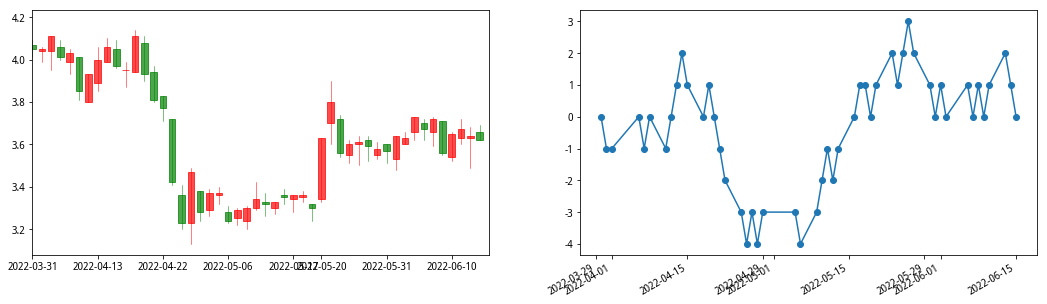

In [10]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign1 = normalize.normalize_monotone()

price.plot.ochl(ax=axes[0])
sign1.plot(marker='o',ax=axes[1]);

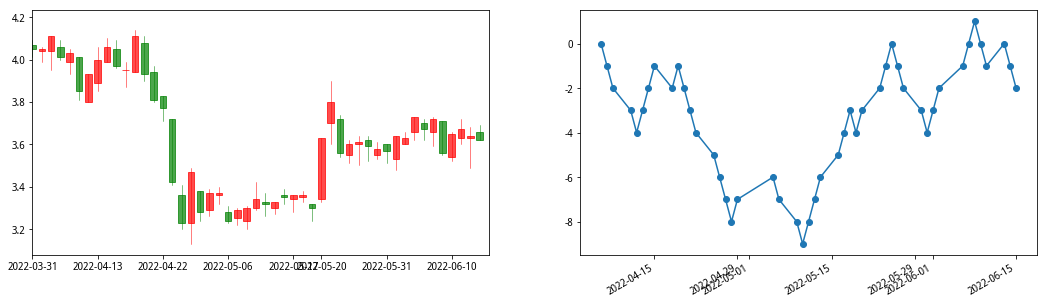

In [11]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign2 = normalize.normalize_movingaverage(5)

price.plot.ochl(ax=axes[0])
sign2.plot(marker='o',ax=axes[1]);

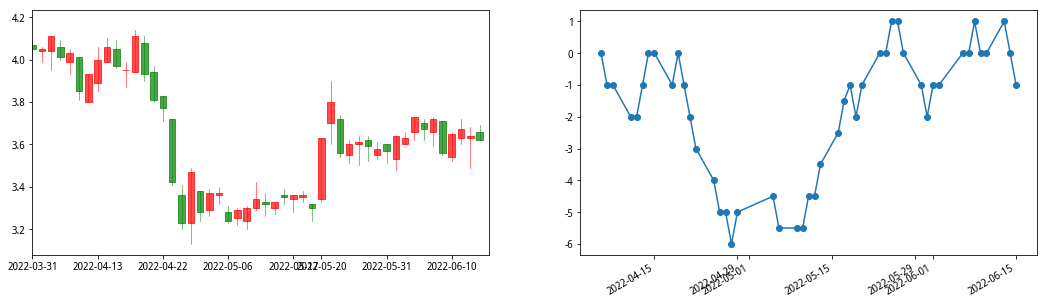

In [12]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign3 = normalize.normalize_compound(5)

price.plot.ochl(ax=axes[0])
sign3.plot(marker='o',ax=axes[1]);

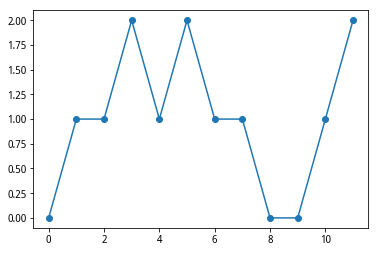

In [13]:
test_value = [0,1,1,2,1,2,1,1,0,0,1,2]
test_ser = pd.Series(data=test_value,index=range(len(test_value)))

test_ser.plot(marker='o');

In [14]:
test_arr = np.array([[0,0,0],
                     [1,1,1],
                     [2,2,2],
                     [3,3,3],
                     [4,4,4],
                     [5,5,5],
                     [6,6,4],
                     [7,7,5],
                     [8,6,6],
                     [9,7,7],
                     [8,8,8]])

df1 = pd.DataFrame(test_arr,columns='A,B,C'.split(','))

In [15]:
def get_act_trend_score(ser: pd.Series) -> Tuple:

    trend_score = Tren_Score(ser)
    trend_score.calc_trend_score('opposite')
    return (trend_score.score['opposite'].act_score,
            trend_score.score['opposite'].trend_score)

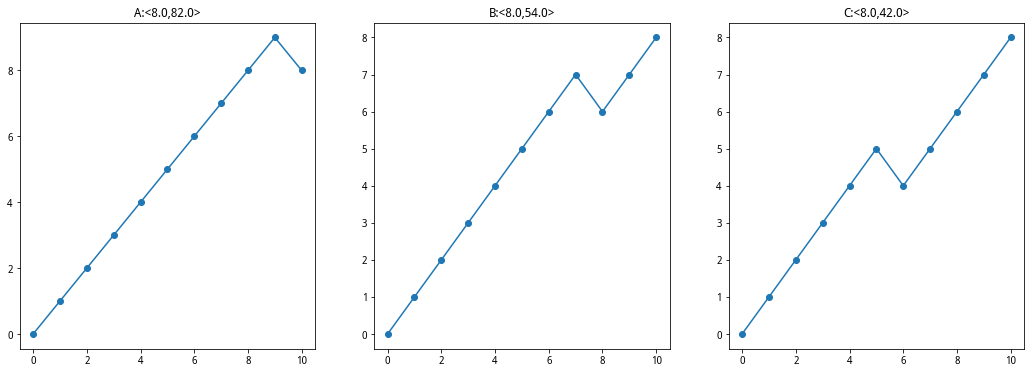

In [16]:
score_df1 = df1.apply(lambda x:get_act_trend_score(x)).T

fif,axes = plt.subplots(1,3,figsize=(18,6))

for ax,(col_name,score_ser),(_,ser_v) in zip(axes,score_df1.T.items(),df1.items()):
    
    a,b = score_ser # 趋,势
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b}>')

In [17]:
test_arr1 = np.array([[0,0,0],
                     [1,1,1],
                     [2,2,2],
                     [1,1,3],
                     [2,2,2],
                     [1,3,3],
                     [2,2,4],
                     [3,3,3],
                     [4,4,4],
                     [5,5,5],
                     [6,6,6]])

df2 = pd.DataFrame(test_arr1,columns='A,B,C'.split(','))

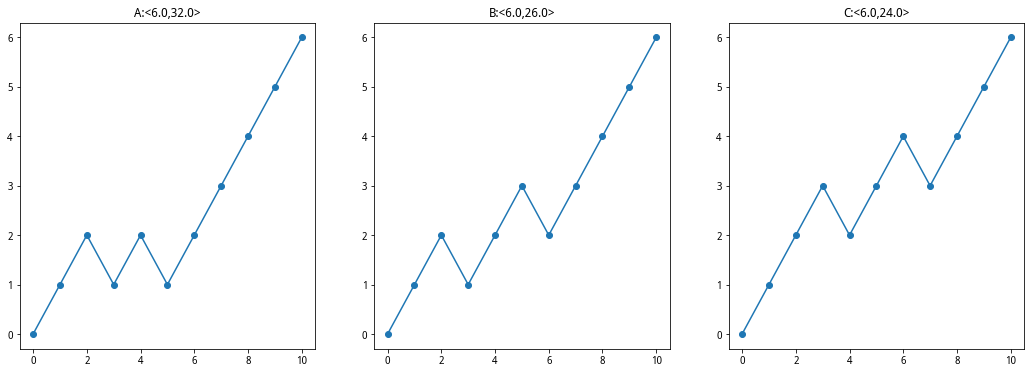

In [18]:
score_df2 = df2.apply(lambda x:get_act_trend_score(x)).T


fif,axes = plt.subplots(1,3,figsize=(18,6))

for ax,(col_name,score_ser),(_,ser_v) in zip(axes,score_df2.T.items(),df2.items()):
    
    a,b = score_ser # 趋,势
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b}>')

In [19]:
test_arr2 = np.array([1,1,0,1,-1,0,-1,1,1,-1,0,0,1,1,1,1,-1,-1,-1])
ser = pd.Series(test_arr2)
cum_ser = ser.cumsum()

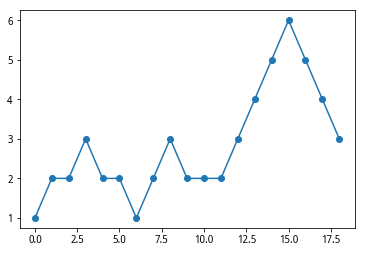

In [20]:
cum_ser.plot(marker='o');

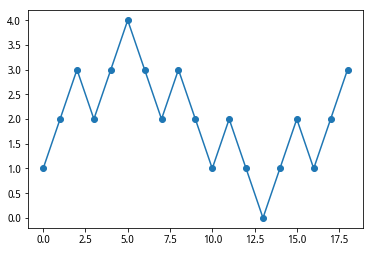

In [21]:
test_arr3 = np.array([1,2,3,2,3,4,3,2,3,2,1,2,1,0,1,2,1,2,3])
ser = pd.Series(test_arr3)

ser.plot(marker='o');

In [22]:
def compare_score(ser: pd.Series) -> Tuple:

    trend_score = Tren_Score(ser)

    trend_score.calc_trend_score(
        'opposite')

    

    trend_score.calc_trend_score(
        'absolute')

    opposite_act_score = trend_score.score['opposite'].act_score
    absolute_act_score = trend_score.score['absolute'].act_score
    opposit_trend_score = trend_score.score['opposite'].trend_score
    absolute_trend_score = trend_score.score['absolute'].trend_score
    return opposite_act_score, absolute_act_score, opposit_trend_score, absolute_trend_score

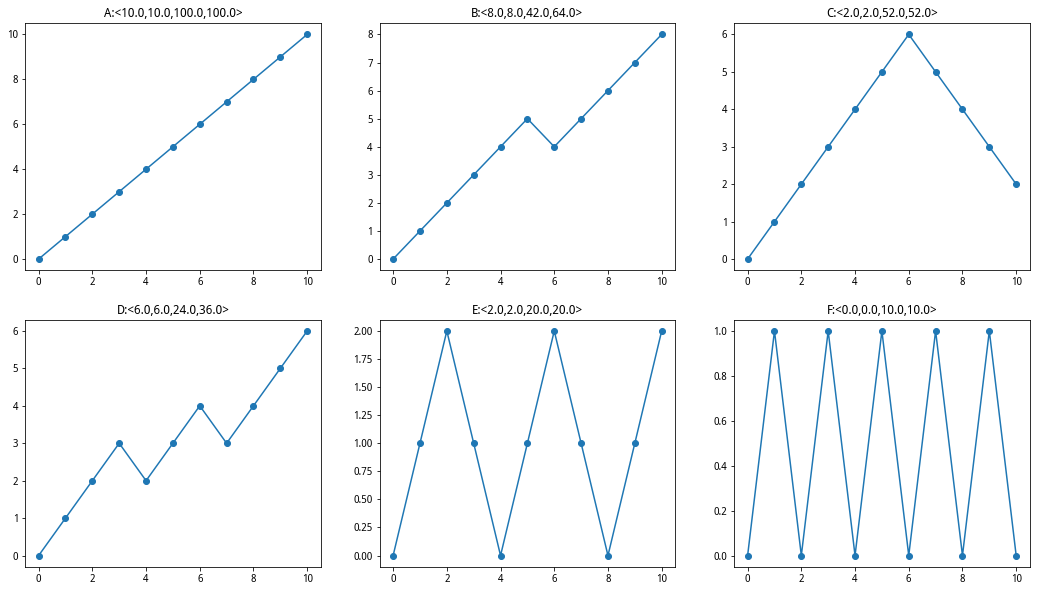

In [23]:
test_arr4 = np.array([[0, 0, 0, 0, 0, 0],
                     [1, 1, 1, 1, 1, 1],
                     [2, 2, 2, 2, 2, 0],
                     [3, 3, 3, 3, 1, 1],
                     [4, 4, 4, 2, 0, 0],
                     [5, 5, 5, 3, 1, 1],
                     [6, 4, 6, 4, 2, 0],
                     [7, 5, 5, 3, 1, 1],
                     [8, 6, 4, 4, 0, 0],
                     [9, 7, 3, 5, 1, 1],
                     [10, 8, 2, 6, 2, 0]])

df4 = pd.DataFrame(test_arr4,columns='A,B,C,D,E,F'.split(','))

score_df3 = df4.apply(compare_score).T

fif,axes = plt.subplots(2,3,figsize=(18,10))

for ax,(col_name,score_ser),(_,ser_v) in zip(np.ravel(axes),score_df3.T.items(),df4.items()):
    
    a,b,c,d = score_ser
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b},{c},{d}>')

In [24]:
hs300 = get_price('000300.XSHG', 
                  start_date='2014-01-01',
                  end_date='2021-10-25', 
                  fields=['close','open','high','low'], 
                  panel=False)

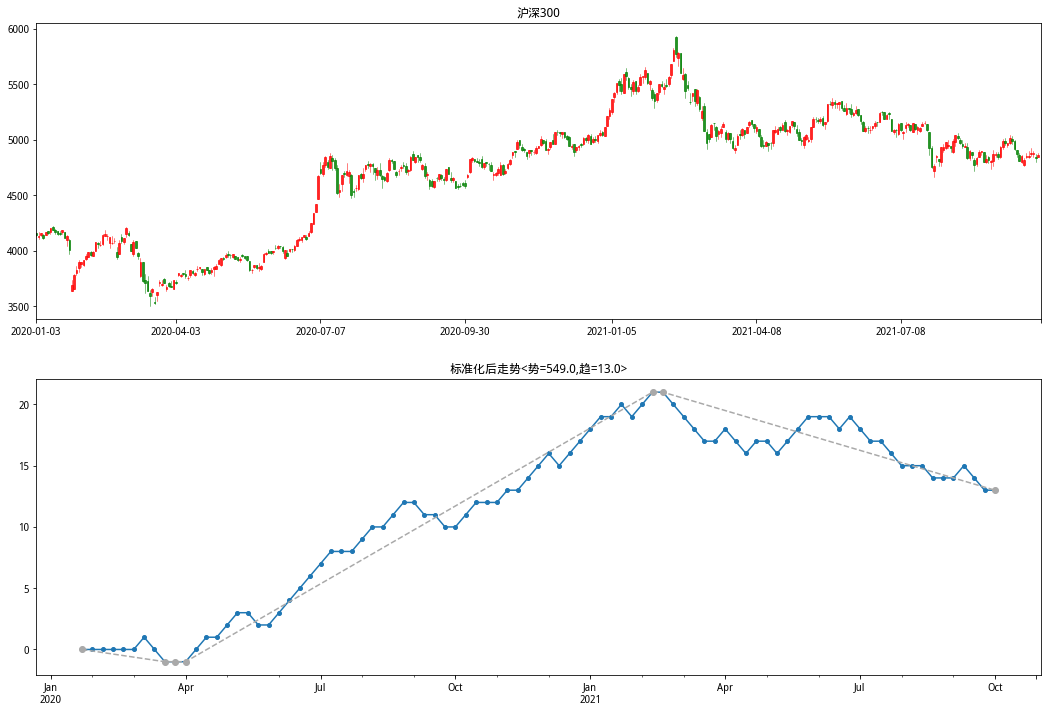

In [25]:
slice_price = hs300.loc['2020-01-01':'2021-10-01','close']

weekly_bar = slice_price.resample('W').last()

normalize = Normalize_Trend(weekly_bar)
normalize_trend_ser = normalize.normalize_compound(5)

trend_score = Tren_Score(normalize_trend_ser)
trend_score.calc_trend_score('absolute')

fig, axes = plt.subplots(2, figsize=(18, 12))

hs300.loc['2020-01-01':'2021-10-01'].plot.ochl(ax=axes[0],title='沪深300')

a = trend_score.score['absolute'].trend_score
b = trend_score.score['absolute'].act_score

axes[1].set_title(f'标准化后走势<势={a},趋={b}>')
normalize_trend_ser.plot(ax=axes[1], marker='o',ms=4)
trend_score.point_frame['absolute'].plot(
    ax=axes[1], marker='o', ls='--', color='darkgray');

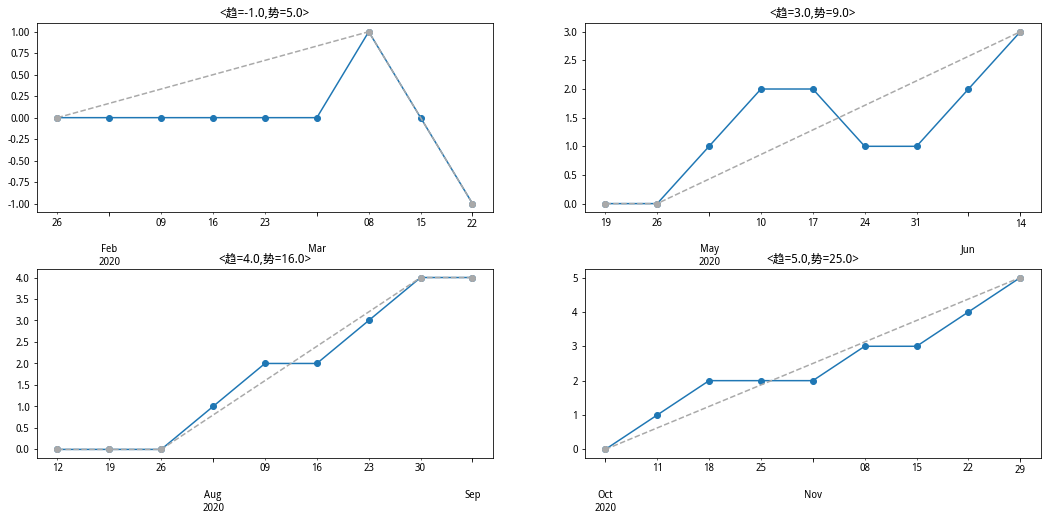

In [26]:
point_list = []
normalize_trend_list = []
score = []
for i in range(12, len(weekly_bar), 12):
    normalize = Normalize_Trend(weekly_bar.iloc[i-12:i])
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)
    normalize_trend_list.append(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')
    score.append((trend_score.score['absolute'].act_score,
                 trend_score.score['absolute'].trend_score))
    point_list.append(trend_score.point_frame['absolute'])

fig, axes = plt.subplots(2, 2, figsize=(18, 4 * 2))

for ax, ser1, ser2, score in zip(np.ravel(axes), normalize_trend_list, point_list,score):
    
    a,b =score
    ser1.plot(ax=ax, marker='o',title=f'<趋={a},势={b}>')
    ser2.plot(ax=ax, marker='o', ls='--', color='darkgray')
    
plt.subplots_adjust(hspace=0.3);

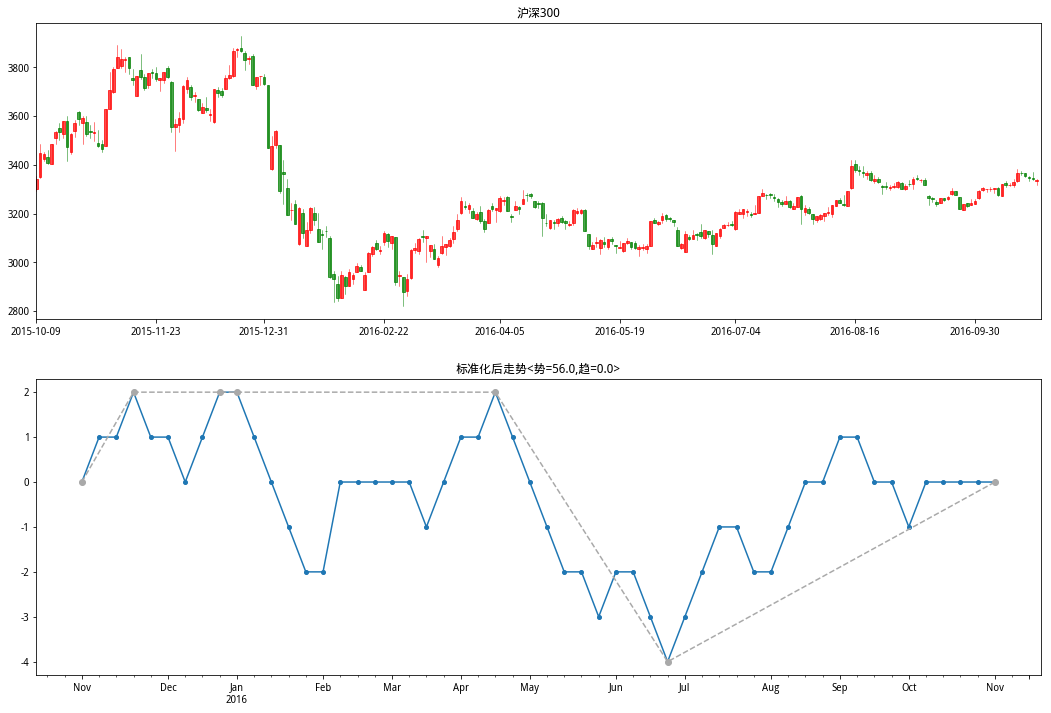

In [27]:
slice_price = hs300.loc['2015-10-01':'2016-10-31', 'close']
weekly_bar = slice_price.resample('W').last()

normalize = Normalize_Trend(weekly_bar)
normalize_trend_ser = normalize.normalize_compound(5)
trend_score = Tren_Score(normalize_trend_ser)
normalize_trend_list.append(normalize_trend_ser)

trend_score.calc_trend_score('absolute')
a = trend_score.score['absolute'].trend_score
b = trend_score.score['absolute'].act_score

fig, axes = plt.subplots(2, figsize=(18, 12))

hs300.loc['2015-10-01':'2016-10-31'].plot.ochl(ax=axes[0],title='沪深300')
axes[1].set_title(f'标准化后走势<势={a},趋={b}>')
normalize_trend_ser.plot(ax=axes[1], marker='o',ms=4)
trend_score.point_frame['absolute'].plot(
    ax=axes[1], marker='o', ls='--', color='darkgray');

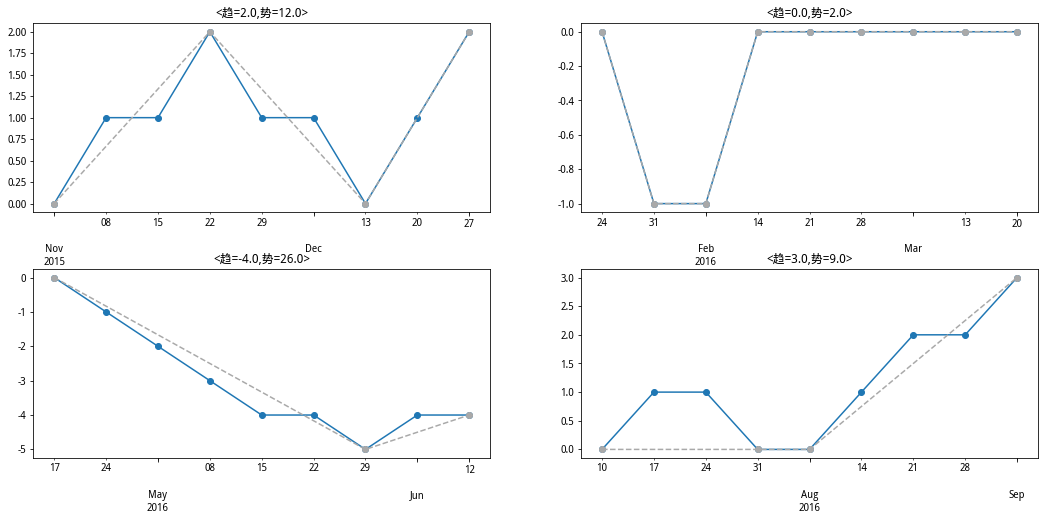

In [28]:
point_list = []
normalize_trend_list = []
score = []
for i in range(12, len(weekly_bar), 12):
    normalize = Normalize_Trend(weekly_bar.iloc[i-12:i])
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)
    normalize_trend_list.append(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')
    score.append((trend_score.score['absolute'].act_score,
             trend_score.score['absolute'].trend_score))
    point_list.append(trend_score.point_frame['absolute'])

fig, axes = plt.subplots(2, 2, figsize=(18, 4 * 2))

for ax, ser1, ser2, score in zip(np.ravel(axes), normalize_trend_list, point_list,score):
    
    a,b =score
    ser1.plot(ax=ax, marker='o',title=f'<趋={a},势={b}>')
    ser2.plot(ax=ax, marker='o', ls='--', color='darkgray')
    
plt.subplots_adjust(hspace=0.3);

In [29]:
data__HYGY = get_price('603799.XSHG', 
                  start_date='2016-01-01',
                  end_date='2022-06-15', 
                  fields=['close','open','high','low'], 
                  panel=False)

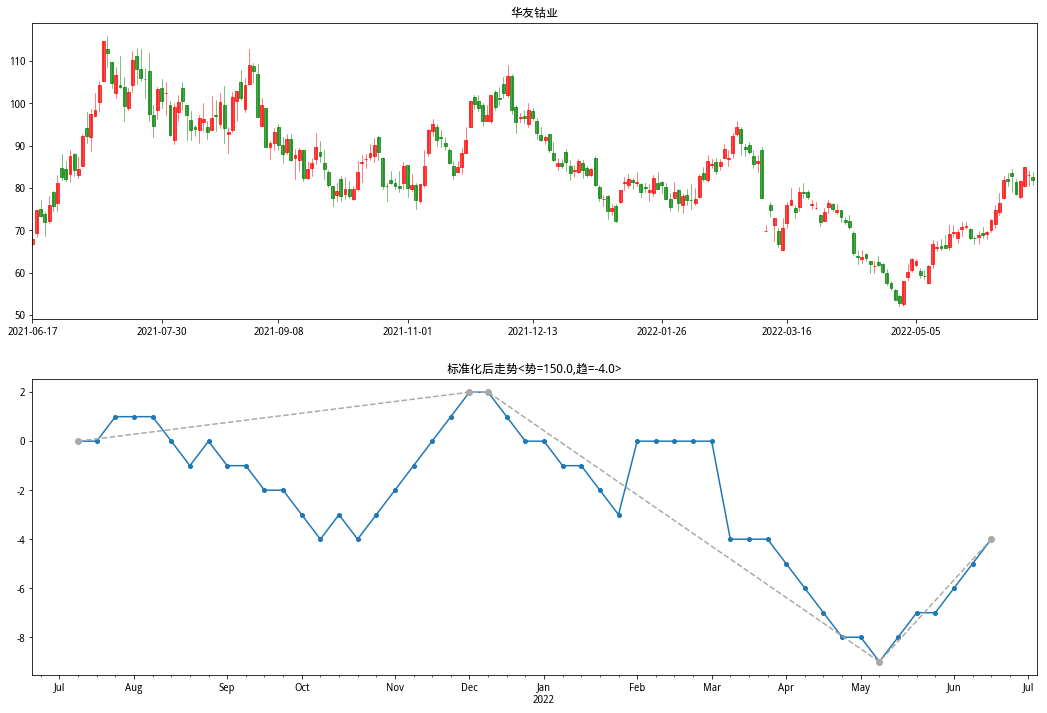

In [30]:
slice_price = data__HYGY.loc['2021-06-16':'2022-06-15','close']

weekly_bar = slice_price.resample('W').last()

normalize = Normalize_Trend(weekly_bar)
normalize_trend_ser = normalize.normalize_compound(5)

trend_score = Tren_Score(normalize_trend_ser)
trend_score.calc_trend_score('absolute')

fig, axes = plt.subplots(2, figsize=(18, 12))

data__HYGY.loc['2021-06-16':'2022-06-15'].plot.ochl(ax=axes[0],title='华友钴业')

a = trend_score.score['absolute'].trend_score
b = trend_score.score['absolute'].act_score

axes[1].set_title(f'标准化后走势<势={a},趋={b}>')
normalize_trend_ser.plot(ax=axes[1], marker='o',ms=4)
trend_score.point_frame['absolute'].plot(
    ax=axes[1], marker='o', ls='--', color='darkgray');

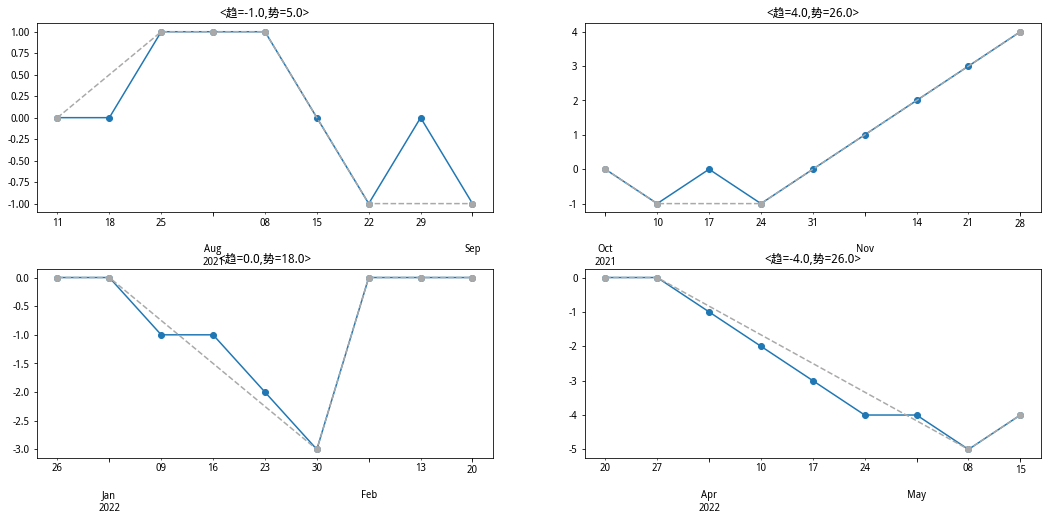

In [31]:
point_list = []
normalize_trend_list = []
score = []
for i in range(12, len(weekly_bar), 12):
    normalize = Normalize_Trend(weekly_bar.iloc[i-12:i])
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)
    normalize_trend_list.append(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')
    score.append((trend_score.score['absolute'].act_score,
             trend_score.score['absolute'].trend_score))
    point_list.append(trend_score.point_frame['absolute'])

fig, axes = plt.subplots(2, 2, figsize=(18, 4 * 2))

for ax, ser1, ser2, score in zip(np.ravel(axes), normalize_trend_list, point_list,score):
    
    a,b =score
    ser1.plot(ax=ax, marker='o',title=f'<趋={a},势={b}>')
    ser2.plot(ax=ax, marker='o', ls='--', color='darkgray')
    
plt.subplots_adjust(hspace=0.3);

In [32]:
def calc_trend_score(ser:pd.Series)->float:
    
    # 转为周度
    #ser = ser.resample('W').last().copy() 
    normalize = Normalize_Trend(ser)

    # 此时是周级别得均线
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')

    return trend_score.score['absolute'].trend_score

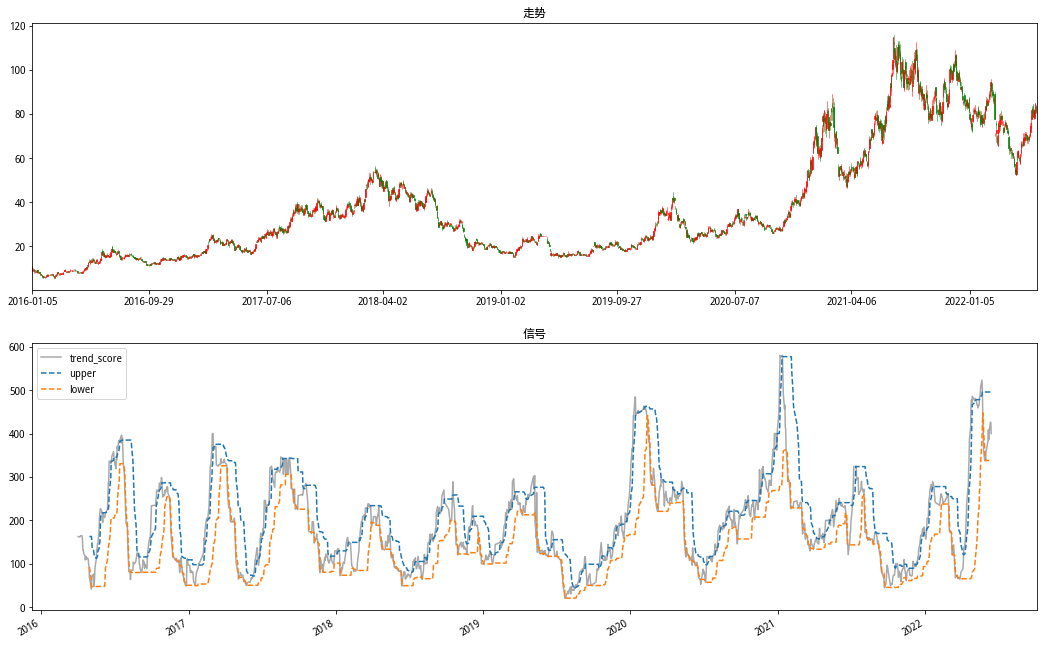

In [33]:
score = data__HYGY['close'].rolling(60).apply(calc_trend_score,raw=False)
lower_bound = score.rolling(20).apply(lambda x: x.quantile(0.05),raw=False)
upper_bound = score.rolling(20).apply(lambda x: x.quantile(0.85),raw=False)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
data__HYGY.plot.ochl(ax=axes[0],title='走势')

axes[1].set_title('信号')
score.plot(ax=axes[1], color='darkgray', label='trend_score')
upper_bound.plot(ax=axes[1], ls='--', label='upper')
lower_bound.plot(ax=axes[1], ls='--', label='lower')

plt.legend();

In [34]:
def get_hold_flag(df:pd.DataFrame)->pd.Series:
    '''
    标记持仓
    ------
    输入参数：
        df:index-date columns-score|lower_bound|upper_bound
    ------
    return index-date 1-持仓;0-空仓
    '''
    flag = pd.Series(index=df.index,data=np.zeros(len(df)))

    for trade,row in df.iterrows():
        
        sign = row['score']
        lower = row['lower_bound']
        upper = row['upper_bound']
        try:
            previous_score
        except NameError:
            previous_score = sign
            previous_lower = lower
            previous_upper = upper
            order_flag = 0
            continue
        
        if previous_score > previous_lower and sign <= lower:
        
            flag[trade] = 0
            order_flag = 0
            
        elif previous_score < previous_upper and sign >= upper:
            flag[trade] = 1
            order_flag = 1

        else:
            
            flag[trade] = order_flag
        
        previous_score = sign
        previous_lower = lower
        previous_upper = upper
            
    return flag

In [35]:
df = pd.concat((score,upper_bound,lower_bound),axis=1)
df.columns = ['score','upper_bound','lower_bound']

flag = get_hold_flag(df)
next_ret = data__HYGY['close'].pct_change().shift(-1)
algorithms_ret = flag * next_ret.loc[flag.index]

algorithms_cum = ep.cum_returns(algorithms_ret)

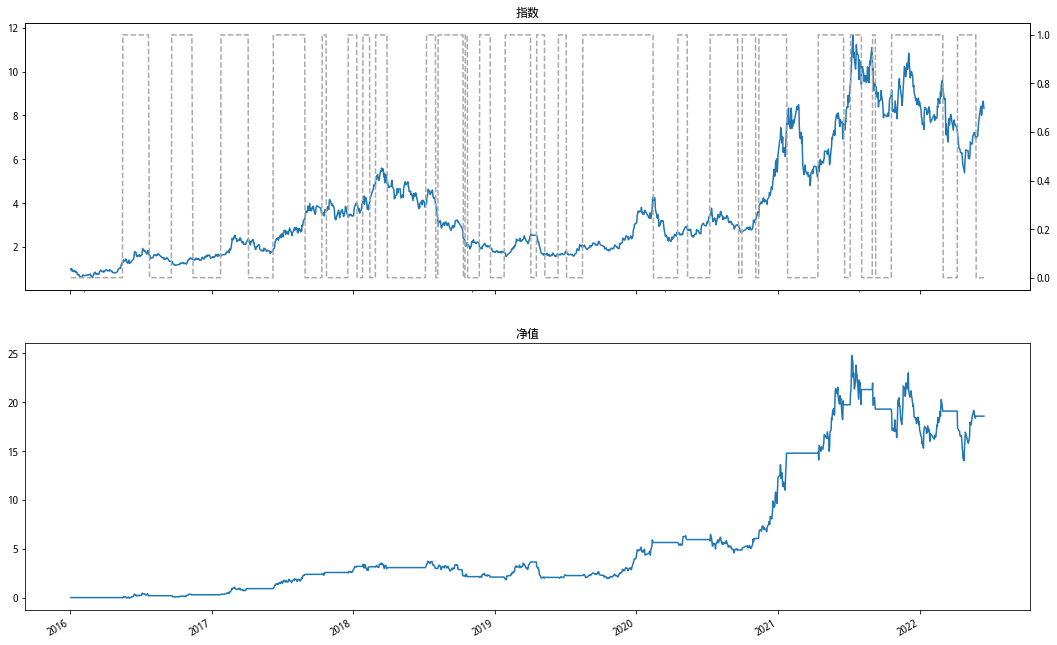

In [36]:
fig,axes = plt.subplots(2,figsize=(18,12))

axes[0].set_title('指数')
(data__HYGY['close']/data__HYGY['close'][0]).plot(ax=axes[0])
axes[1].set_title('净值')
flag.plot(ax=axes[0],secondary_y=True,ls='--',color='darkgray')
algorithms_cum.plot(ax=axes[1]);

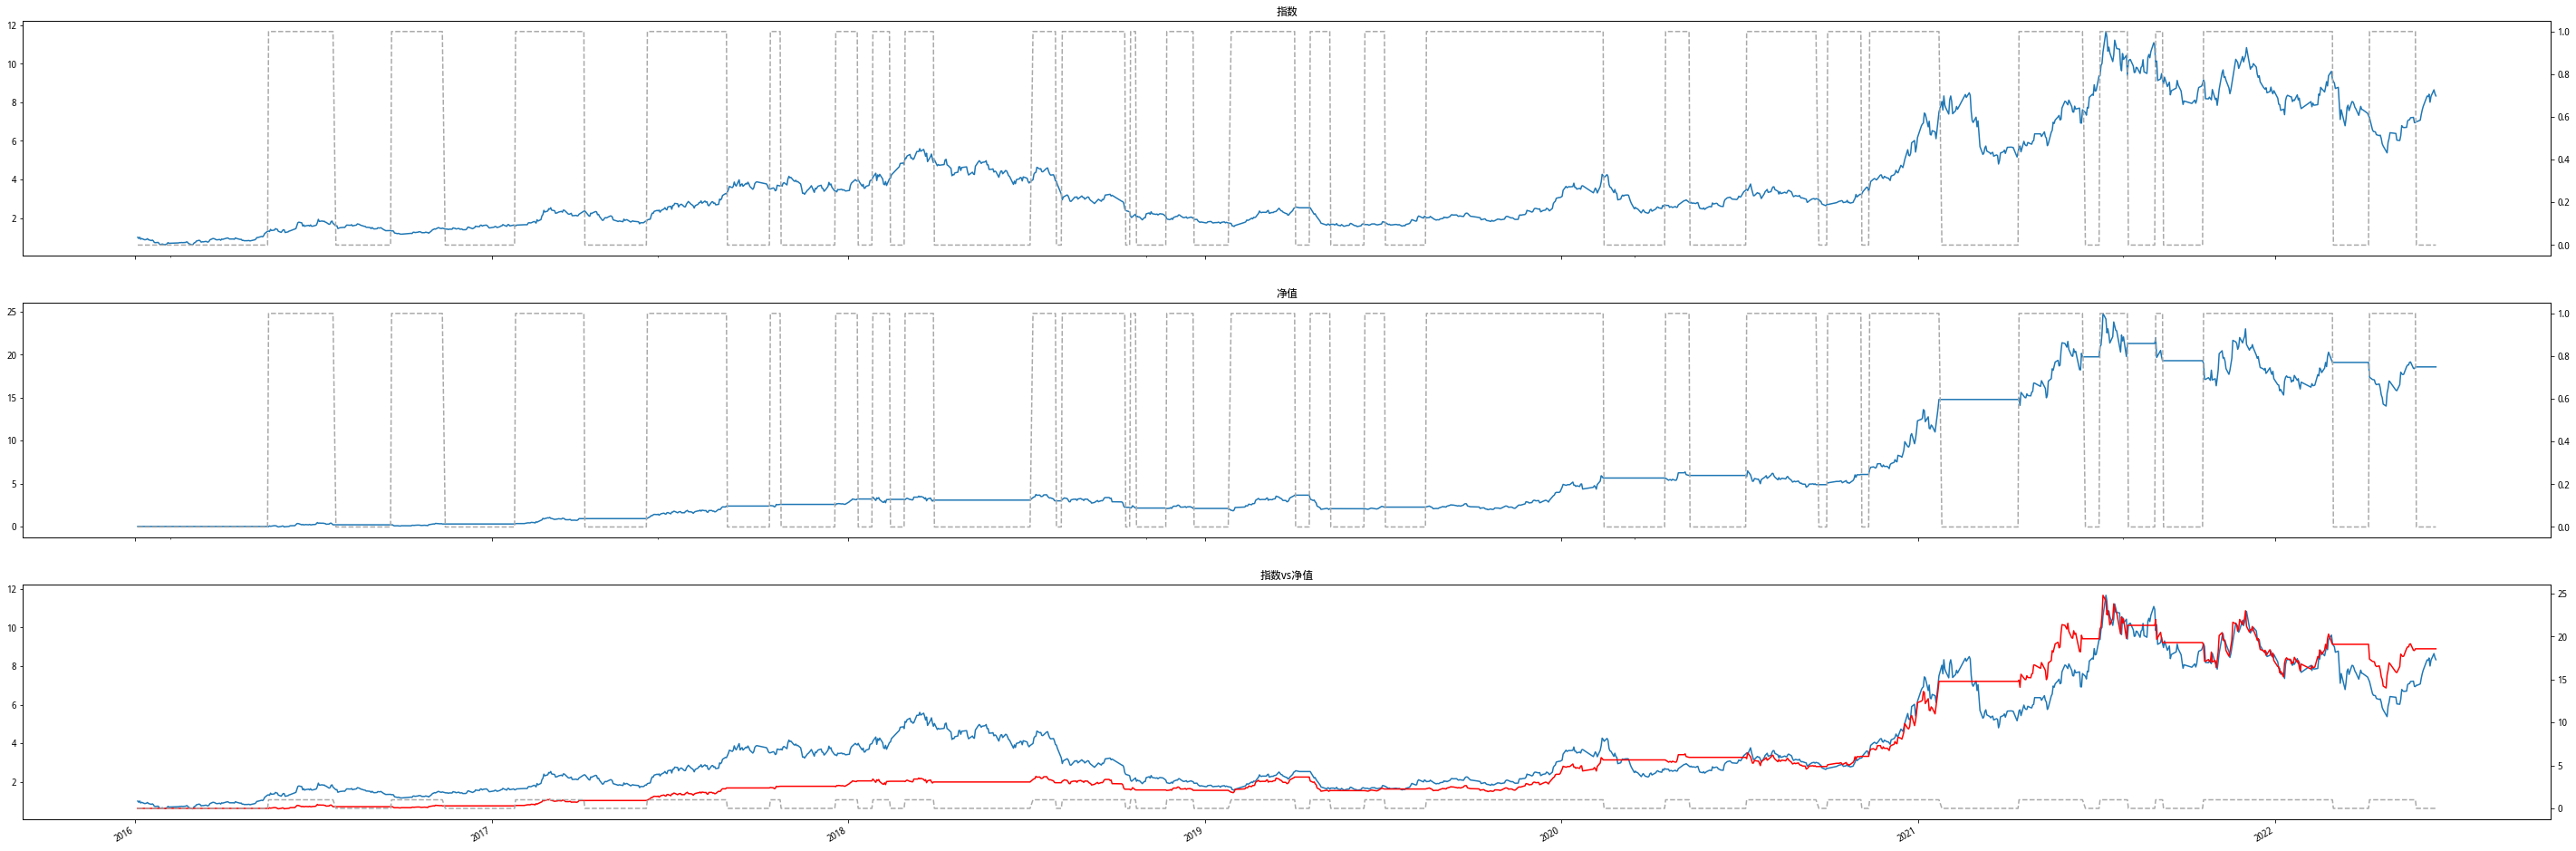

In [49]:
fig,axes = plt.subplots(3,figsize=(50,18))

axes[0].set_title('指数')
# axes[0].set_yscale('log')
(data__HYGY['close']/data__HYGY['close'][0]).plot(ax=axes[0])
axes[1].set_title('净值')
# axes[1].set_yscale('log')
flag.plot(ax=axes[0],secondary_y=True,ls='--',color='darkgray')
algorithms_cum.plot(ax=axes[1]);
flag.plot(ax=axes[1],secondary_y=True,ls='--',color='darkgray')
axes[2].set_title('指数vs净值')
# axes[2].set_yscale('log')
(data__HYGY['close']/data__HYGY['close'][0]).plot(ax=axes[2])
algorithms_cum.plot(ax=axes[2],color='red',secondary_y=True);
flag.plot(ax=axes[2],ls='--',secondary_y=True,color='darkgray')